# Experiments with p4679 and Cascadia
## Imports and set directories

In [21]:
# Imports
import sys
from utils.paths import MAIN_DIRECTORY, REL_DATA_DIR
if MAIN_DIRECTORY not in sys.path:
    sys.path.append(MAIN_DIRECTORY)

# Import relevant libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.data_preprocessing import moving_average_causal_filter, create_dataset, split_train_test_forecast_windows, normalise_dataset
from utils.plotting import plot_example_sample,  plot_single_seg_result
from utils.nn_train import train_model, eval_model_on_test_set
from scripts.models.tcn_oneshot_multistep import MultiStepTCN
import scripts.models.lstm_oneshot_multistep as lstm

# Set random seed and torch device
SEED = 42 # random seed for the dataset and model
set_seed(SEED)
device = set_torch_device()
#device = "cpu" # Manual Override

GPU name: NVIDIA GeForce RTX 3050 Laptop GPU
Max GPU memory: 4.094164992 GiB


## Load p4679 and p4679 into dataframes

In [22]:
# Load p4679 data (average for segment 1)

exp = "cascadia"
dataset = SlowEarthquakeDataset(exp)
df_cascadia = pd.DataFrame(SlowEarthquakeDataset.convert_to_df(dataset, exp)["seg_avg"].rename("signal"))

print("df_cascadia:")
print(df_cascadia.head())
print(df_cascadia.shape)

# Load full p4679 dataset

p4679_FILE_PATH = f"{MAIN_DIRECTORY}/{REL_DATA_DIR}/gtc_quakes_data/labquakes/Marone/p4679/p4679.txt"

df_p4679 = pd.read_csv(
    p4679_FILE_PATH, 
    skiprows=2, 
    usecols=["shr_stress", "time"],
    names=[
        "id", "lp_disp", "shr_stress", "nor_disp", "nor_stress", 
        "time", "mu", "layer_thick", "ec_disp"
    ], 
)

df_p4679_300s = df_p4679[(df_p4679["time"] >= 4233.28) & (df_p4679["time"] <= 4533.28)].reset_index(drop=True)
df_p4679 = df_p4679[(df_p4679["time"] >= 4233.28) & (df_p4679["time"] <= 5159.292)].reset_index(drop=True)

df_p4679_300s = df_p4679_300s.rename(columns={"shr_stress": "signal"}).drop(columns=["time"])  # Remove 'time' column
df_p4679 = df_p4679.rename(columns={"shr_stress": "signal"}).drop(columns=["time"])  # Remove 'time' column

print("\n----------------")
print("df_p4679:")
print(df_p4679.head())
print(df_p4679.shape)

print("\n----------------")
print("df_p4679_300s:")
print(df_p4679_300s.head())
print(df_p4679_300s.shape)

df_cascadia:
         signal
0  1.510314e+08
1  1.256806e+08
2  1.074901e+08
3  1.447256e+08
4  1.787377e+08
(3883, 1)

----------------
df_p4679:
     signal
0  5.091520
1  5.090652
2  5.089989
3  5.089492
4  5.088243
(926013, 1)

----------------
df_p4679_300s:
     signal
0  5.091520
1  5.090652
2  5.089989
3  5.089492
4  5.088243
(300001, 1)


## Pre-processing
### Smooth both dataframes and downsample p4679 so it matches p4679

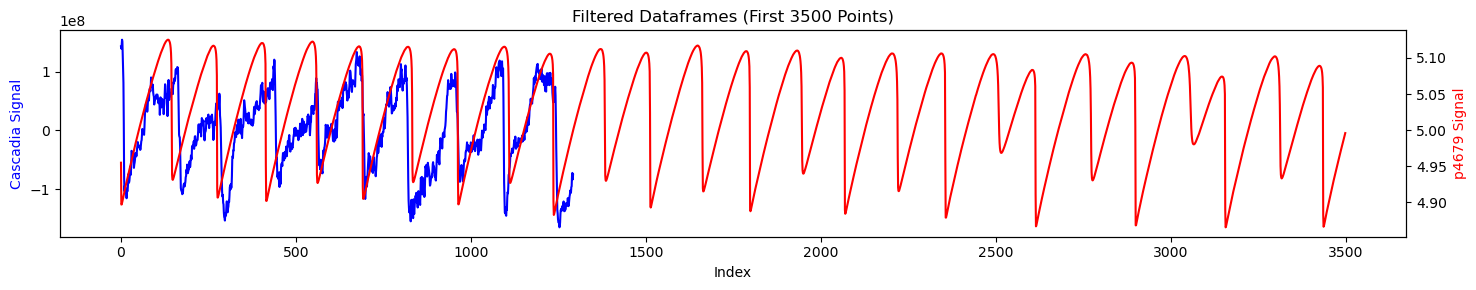

In [23]:
efficiency_factor = 1

df_cascadia_filtered = moving_average_causal_filter(df_cascadia, 5, 1*efficiency_factor)
df_p4679_filtered = moving_average_causal_filter(df_p4679, 13, 13*efficiency_factor)
df_p4679_300s_filtered = moving_average_causal_filter(df_p4679_300s, 13, 13*efficiency_factor)

fig, ax1 = plt.subplots(figsize=(15, 3))

# Plot Cascadia dataframe on the left y-axis without legend
df_cascadia_filtered[:3500].plot(ax=ax1, y='signal', color='blue', legend=False)
ax1.set_xlabel('Index')
ax1.set_ylabel('Cascadia Signal', color='blue')
ax1.grid(False)

# Create a secondary y-axis for p4679 dataframe without legend
ax2 = ax1.twinx()
df_p4679_filtered[:3500].plot(ax=ax2, y='signal', color='red', legend=False)
ax2.set_ylabel('p4679 Signal', color='red')
ax2.grid(False)

plt.title('Filtered Dataframes (First 3500 Points)')
plt.tight_layout()
plt.show()

### Create Xs and ys

In [24]:
# Dataset parameters
LOOKBACK, FORECAST = int(600/efficiency_factor), int(60/efficiency_factor)  # lookback and forecast values

# Pre-process the data into windows
X_cascadia, y_cascadia = create_dataset(df_cascadia_filtered, LOOKBACK, FORECAST)
X_cascadia = X_cascadia.squeeze(-1)
y_cascadia = y_cascadia.squeeze(-1)
print(f"Cascadia X and y shapes:\t{X_cascadia.shape}\t\t{y_cascadia.shape}")

X_p4679, y_p4679 = create_dataset(df_p4679_filtered, LOOKBACK, FORECAST)
X_p4679 = X_p4679.squeeze(-1)
y_p4679 = y_p4679.squeeze(-1)
print(f"p4679 X and y shapes:\t\t{X_p4679.shape}\t{y_p4679.shape}")

X_p4679_300s, y_p4679_300s = create_dataset(df_p4679_300s_filtered, LOOKBACK, FORECAST)
X_p4679_300s = X_p4679_300s.squeeze(-1)
y_p4679_300s = y_p4679_300s.squeeze(-1)
print(f"p4679_300s X and y shapes:\t{X_p4679_300s.shape}\t{y_p4679_300s.shape}")

Cascadia X and y shapes:	torch.Size([1074, 200])		torch.Size([1074, 20])
p4679 X and y shapes:		torch.Size([23524, 200])	torch.Size([23524, 20])
p4679_300s X and y shapes:	torch.Size([7473, 200])	torch.Size([7473, 20])


### Train-Val-Test Split

In [25]:
N_FORECAST_WINDOWS = int(20/efficiency_factor) # n forecasted windows in test set
N_VALIDATION_WINDOWS = int(20/efficiency_factor) # n forecasted windows in validation set

# Split cascadia into train-val-test sets
X_train_cascadia, y_train_cascadia, X_val_cascadia, y_val_cascadia, X_test_cascadia, y_test_cascadia, = split_train_test_forecast_windows(X_cascadia, y_cascadia, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS)

print("Cascadia dataset statistics:")
print(f"Training data shapes:\t\t{X_train_cascadia.shape}\t\t{y_train_cascadia.shape}")
print(f"Testing data shapes:\t\t{X_test_cascadia.shape}\t\t{y_test_cascadia.shape}")
print(f"Validation data shapes:\t\t{X_val_cascadia.shape}\t\t{y_val_cascadia.shape}")

# # Split p4679 into train-val-test sets
X_train_p4679, y_train_p4679, X_val_p4679, y_val_p4679, X_test_p4679, y_test_p4679, = split_train_test_forecast_windows(X_p4679, y_p4679, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS)

print("----------------------------------")
print("p4679 dataset statistics:")
print(f"Training data shapes:\t\t{X_train_p4679.shape}\t{y_train_p4679.shape}")
print(f"Testing data shapes:\t\t{X_test_p4679.shape}\t\t{y_test_p4679.shape}")
print(f"Validation data shapes:\t\t{X_val_p4679.shape}\t\t{y_val_p4679.shape}")

# # Split p4679_300s into train-val-test sets
X_train_p4679_300s, y_train_p4679_300s, X_val_p4679_300s, y_val_p4679_300s, X_test_p4679_300s, y_test_p4679_300s, = split_train_test_forecast_windows(X_p4679_300s, y_p4679_300s, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS)

print("----------------------------------")
print("p4679_300s dataset statistics:")
print(f"Training data shapes:\t\t{X_train_p4679_300s.shape}\t{y_train_p4679_300s.shape}")
print(f"Testing data shapes:\t\t{X_test_p4679_300s.shape}\t\t{y_test_p4679_300s.shape}")
print(f"Validation data shapes:\t\t{X_val_p4679_300s.shape}\t\t{y_val_p4679_300s.shape}")

Cascadia dataset statistics:
Training data shapes:		torch.Size([820, 200])		torch.Size([820, 20])
Testing data shapes:		torch.Size([120, 200])		torch.Size([120, 20])
Validation data shapes:		torch.Size([120, 200])		torch.Size([120, 20])
----------------------------------
p4679 dataset statistics:
Training data shapes:		torch.Size([23280, 200])	torch.Size([23280, 20])
Testing data shapes:		torch.Size([120, 200])		torch.Size([120, 20])
Validation data shapes:		torch.Size([120, 200])		torch.Size([120, 20])
----------------------------------
p4679_300s dataset statistics:
Training data shapes:		torch.Size([7220, 200])	torch.Size([7220, 20])
Testing data shapes:		torch.Size([120, 200])		torch.Size([120, 20])
Validation data shapes:		torch.Size([120, 200])		torch.Size([120, 20])


### Normalise with scalar based on training set

In [26]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
cascadia_data_dict, cascadia_scaler_X, cascadia_scaler_y = normalise_dataset(X_train_cascadia, y_train_cascadia, X_test_cascadia, y_test_cascadia, X_val_cascadia, y_val_cascadia)

print(f"Cascadia Data Dictionary keys:\t{cascadia_data_dict.keys()}")

p4679_data_dict, p4679_scaler_X, p4679_scaler_y = normalise_dataset(X_train_p4679, y_train_p4679, X_test_p4679, y_test_p4679, X_val_p4679, y_val_p4679)

print(f"p4679 Data Dictionary keys:\t{p4679_data_dict.keys()}")

p4679_300s_data_dict, p4679_300s_scaler_X, p4679_300s_scaler_y = normalise_dataset(X_train_p4679_300s, y_train_p4679_300s, X_test_p4679_300s, y_test_p4679_300s, X_val_p4679_300s, y_val_p4679_300s)

print(f"p4679_300s Data Dictionary keys:\t{p4679_300s_data_dict.keys()}")

Cascadia Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])
p4679 Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])
p4679_300s Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])


### Visualise pre-processed data

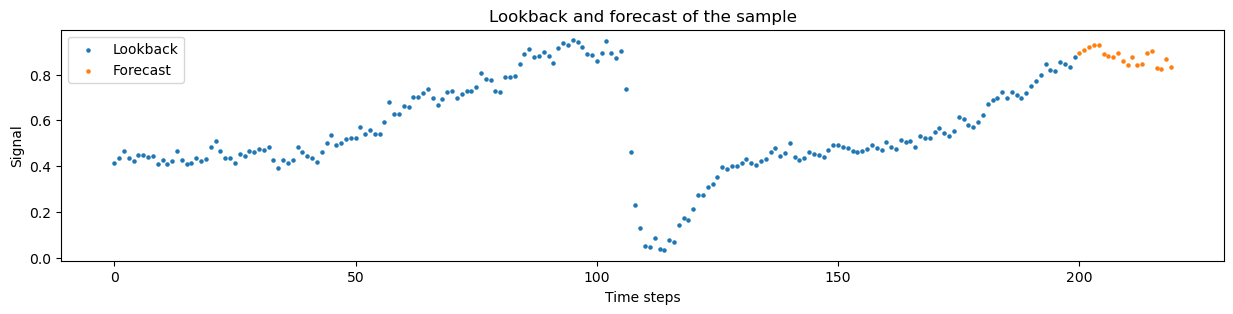

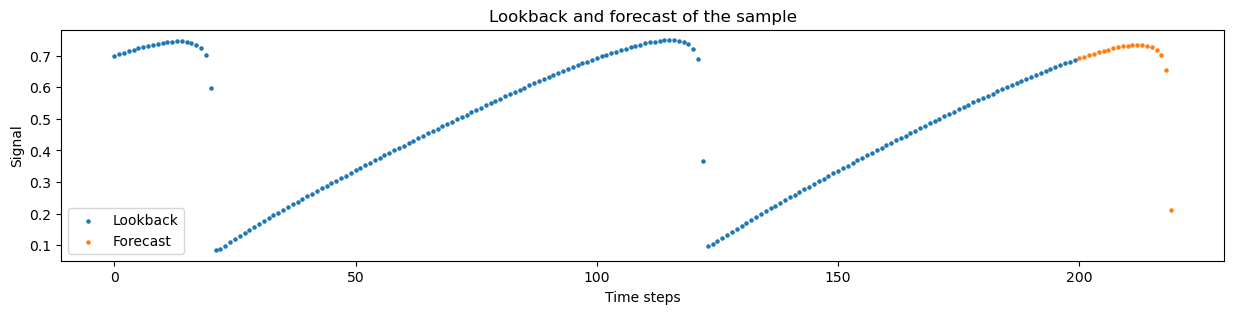

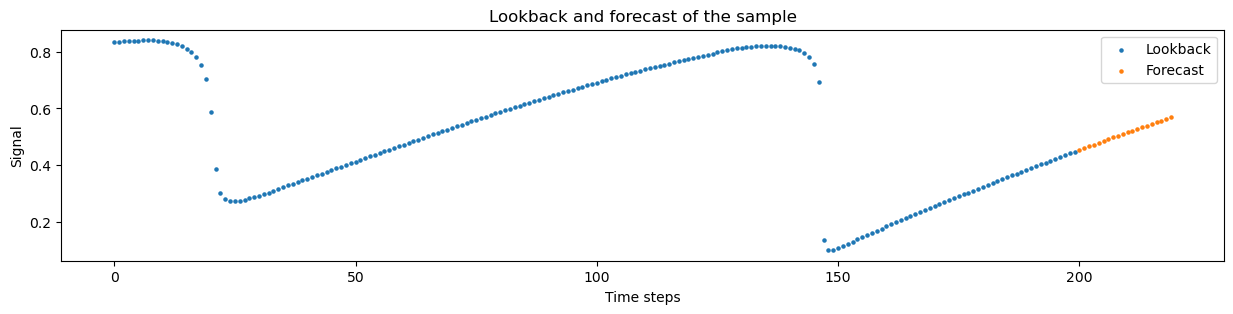

In [27]:
plot_example_sample(cascadia_data_dict["X_test_sc"], cascadia_data_dict["y_test_sc"], int(100/efficiency_factor), LOOKBACK, FORECAST)
plot_example_sample(p4679_data_dict["X_test_sc"], p4679_data_dict["y_test_sc"], int(100/efficiency_factor), LOOKBACK, FORECAST)
plot_example_sample(p4679_300s_data_dict["X_test_sc"], p4679_300s_data_dict["y_test_sc"], int(100/efficiency_factor), LOOKBACK, FORECAST)

## Initialise and train models

In [28]:
# Model variables
N_VARIATES = 1
HIDDEN_SIZE = 50
KERNEL_SIZE = 3
OUTPUT_SIZE = FORECAST
DROPOUT = 0
N_EPOCHS = 75
N_LAYERS = 1

# Plot variables
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 2600
ZOOM_MAX = 2800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

In [29]:
# Function to calculate the total size of tensors in a data dictionary
def calculate_total_size(data_dict):
    total_size_bytes = 0
    for key, tensor in data_dict.items():
        element_size = tensor.element_size()  # Size of each element in bytes
        num_elements = tensor.nelement()  # Number of elements in the tensor
        total_size_bytes += element_size * num_elements
    return total_size_bytes / 1e6  # Convert to megabytes

print(f"Cascadia data dictionary size: {calculate_total_size(cascadia_data_dict)} MB")
print(f"p4679 data dictionary size: {calculate_total_size(p4679_data_dict)} MB")
print(f"p4679_300s data dictionary size: {calculate_total_size(p4679_300s_data_dict)} MB")

Cascadia data dictionary size: 1.8656 MB
p4679 data dictionary size: 41.3952 MB
p4679_300s data dictionary size: 13.1296 MB


In [30]:
# Train Cascadia Model


model_cascadia = MultiStepTCN(N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE,  DROPOUT).to(device)
# model_cascadia = lstm.MultiStepLSTMSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

cascadia_results_dict = train_model(model_cascadia, N_EPOCHS, cascadia_data_dict, cascadia_scaler_y, device)

cascadia_results_dict = eval_model_on_test_set(model_cascadia, cascadia_results_dict, cascadia_data_dict, cascadia_scaler_y, device)


/home/tom-ratsakatika/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model on cuda


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [75/75], Train RMSE: 22104266.0000, Val RMSE: 56674532.0000: 100%|██████████| 75/75 [00:05<00:00, 14.79it/s]


In [31]:
# Train p4679 Model

model_p4679 = MultiStepTCN(N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE,  DROPOUT).to(device)
# model_p4679 = lstm.MultiStepLSTMSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

p4679_results_dict = train_model(model_p4679, N_EPOCHS, p4679_data_dict, p4679_scaler_y, device)

p4679_results_dict = eval_model_on_test_set(model_p4679, p4679_results_dict, p4679_data_dict, p4679_scaler_y, device)


/home/tom-ratsakatika/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model on cuda


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [75/75], Train RMSE: 0.0196, Val RMSE: 0.0210: 100%|██████████| 75/75 [02:21<00:00,  1.89s/it]


In [32]:
# Train p4679_300s Model

model_p4679_300s = MultiStepTCN(N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE,  DROPOUT).to(device)
# model_p4679_300s = lstm.MultiStepLSTMSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

p4679_300s_results_dict = train_model(model_p4679_300s, N_EPOCHS, p4679_300s_data_dict, p4679_300s_scaler_y, device)

p4679_300s_results_dict = eval_model_on_test_set(model_p4679_300s, p4679_300s_results_dict, p4679_300s_data_dict, p4679_300s_scaler_y, device)


/home/tom-ratsakatika/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model on cuda


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [75/75], Train RMSE: 0.0168, Val RMSE: 0.0235: 100%|██████████| 75/75 [00:44<00:00,  1.70it/s]


In [60]:
p4679_300s_model_eval_on_900s_test_results_dict = {}

p4679_results_dict = eval_model_on_test_set(model_p4679, p4679_results_dict, p4679_data_dict, p4679_scaler_y, device)
p4679_300s_model_eval_on_900s_test_results_dict = eval_model_on_test_set(model_p4679_300s, p4679_300s_model_eval_on_900s_test_results_dict, p4679_data_dict, p4679_scaler_y, device)

print("p4679 model (900s) RMSE:", p4679_results_dict["test_rmse_list"])

print("p4679 model (300s) evaluated on p4679 (900s) test set RMSE:", p4679_300s_model_eval_on_900s_test_results_dict["test_rmse_list"])

print("--------------------")

print("p4679 model (900s) R^2:", p4679_results_dict["test_r2_list"])

print("p4679 model (300s) evaluated on p4679 (900s) test set R^2:", p4679_300s_model_eval_on_900s_test_results_dict["test_r2_list"])

p4679 model (900s) RMSE: 0.02352656051516533
p4679 model (300s) evaluated on p4679 (900s) test set RMSE: 0.1179533302783966
--------------------
p4679 model (900s) R^2: 0.8570821466358078
p4679 model (300s) evaluated on p4679 (900s) test set R^2: -2.599499980860558


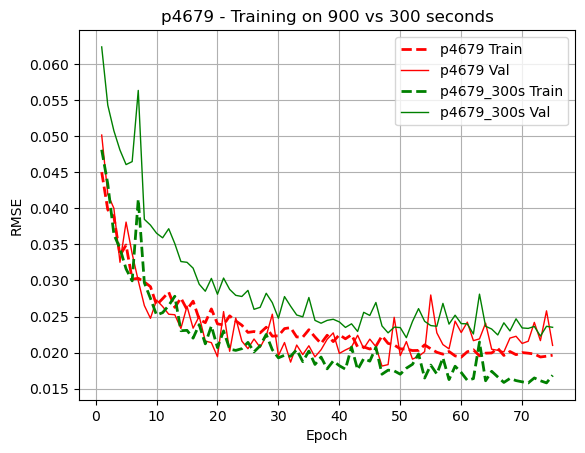

p4679 model (900s) Train RMSE: 0.019633039832115173
p4679 model (900s) Val RMSE: 0.020999491214752197
p4679 model (900s) Test RMSE: 0.02352656051516533
--------------------
p4679 model (300s) Train RMSE: 0.016847919672727585
p4679 model (300s) Val RMSE: 0.02350471168756485
p4679 model (300s) Test RMSE: 0.015639543533325195


In [75]:
# Plot p4679 train and val RMSE
plt.plot(range(1, N_EPOCHS + 1), p4679_results_dict["train_rmse_list"], color='red', linestyle='--', linewidth=2, label='p4679 Train')
plt.plot(range(1, N_EPOCHS + 1), p4679_results_dict["val_rmse_list"], color='red', linestyle='-', linewidth=1, label='p4679 Val')

# Plot p4679_300s train and val RMSE
plt.plot(range(1, N_EPOCHS + 1), p4679_300s_results_dict["train_rmse_list"], color='green', linestyle='--', linewidth=2, label='p4679_300s Train')
plt.plot(range(1, N_EPOCHS + 1), p4679_300s_results_dict["val_rmse_list"], color='green', linestyle='-', linewidth=1, label='p4679_300s Val')

plt.title('p4679 - Training on 900 vs 300 seconds')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.yticks(np.arange(0.015, max(p4679_results_dict["train_rmse_list"] + p4679_results_dict["val_rmse_list"] + p4679_300s_results_dict["train_rmse_list"] + p4679_300s_results_dict["val_rmse_list"]), 0.005))
plt.grid(True) 
plt.show()

print("p4679 model (900s) Train RMSE:", p4679_results_dict["train_rmse_list"][-1])
print("p4679 model (900s) Val RMSE:", p4679_results_dict["val_rmse_list"][-1])
print("p4679 model (900s) Test RMSE:", p4679_results_dict["test_rmse_list"])

print("--------------------")

print("p4679 model (300s) Train RMSE:", p4679_300s_results_dict["train_rmse_list"][-1])
print("p4679 model (300s) Val RMSE:", p4679_300s_results_dict["val_rmse_list"][-1])
print("p4679 model (300s) Test RMSE:", p4679_300s_results_dict["test_rmse_list"])



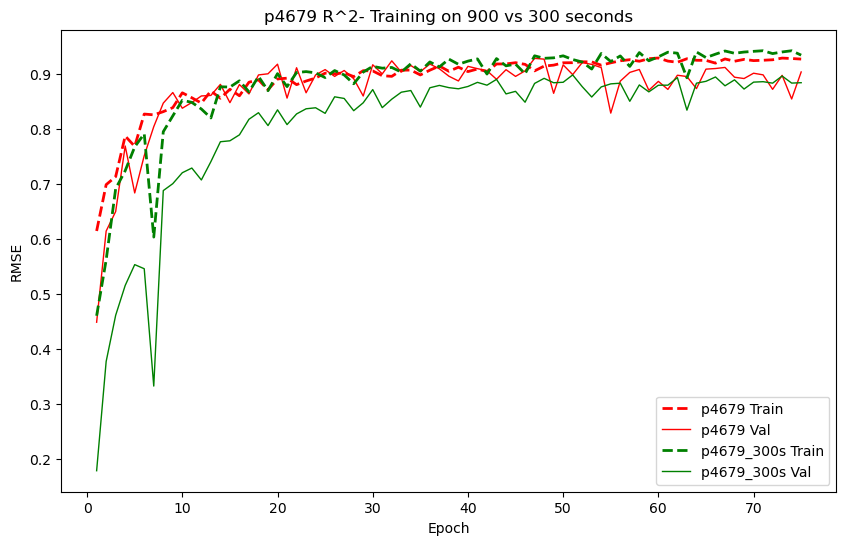

In [62]:
plt.figure(figsize=(10, 6))

# Plot p4679 train and val RMSE
plt.plot(range(1, N_EPOCHS + 1), p4679_results_dict["train_r2_list"], color='red', linestyle='--', linewidth=2, label='p4679 Train')
plt.plot(range(1, N_EPOCHS + 1), p4679_results_dict["val_r2_list"], color='red', linestyle='-', linewidth=1, label='p4679 Val')

# Plot p4679_300s train and val RMSE
plt.plot(range(1, N_EPOCHS + 1), p4679_300s_results_dict["train_r2_list"], color='green', linestyle='--', linewidth=2, label='p4679_300s Train')
plt.plot(range(1, N_EPOCHS + 1), p4679_300s_results_dict["val_r2_list"], color='green', linestyle='-', linewidth=1, label='p4679_300s Val')

plt.title('p4679 R^2- Training on 900 vs 300 seconds')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

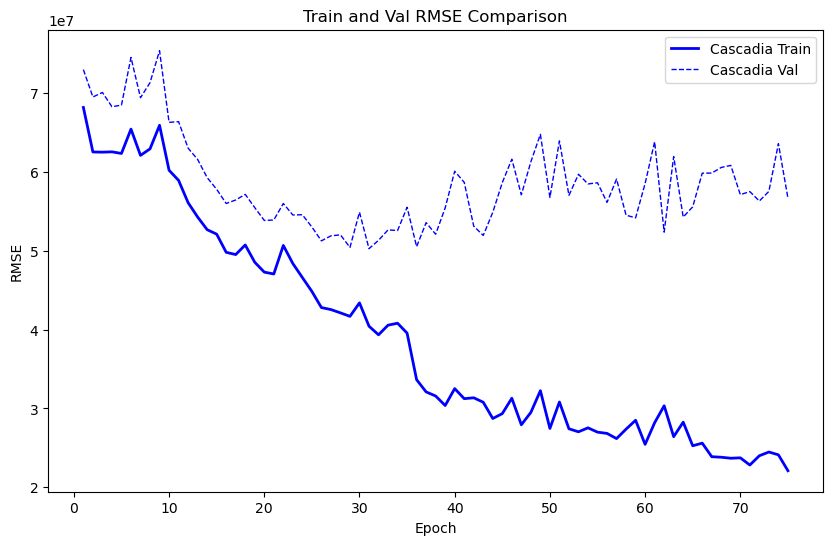

In [34]:
plt.figure(figsize=(10, 6))

# Plot Cascadia train and val RMSE
plt.plot(range(1, N_EPOCHS + 1), cascadia_results_dict["train_rmse_list"], color='blue', linestyle='-', linewidth=2, label='Cascadia Train')
plt.plot(range(1, N_EPOCHS + 1), cascadia_results_dict["val_rmse_list"], color='blue', linestyle='--', linewidth=1, label='Cascadia Val')


plt.title('Train and Val RMSE Comparison')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

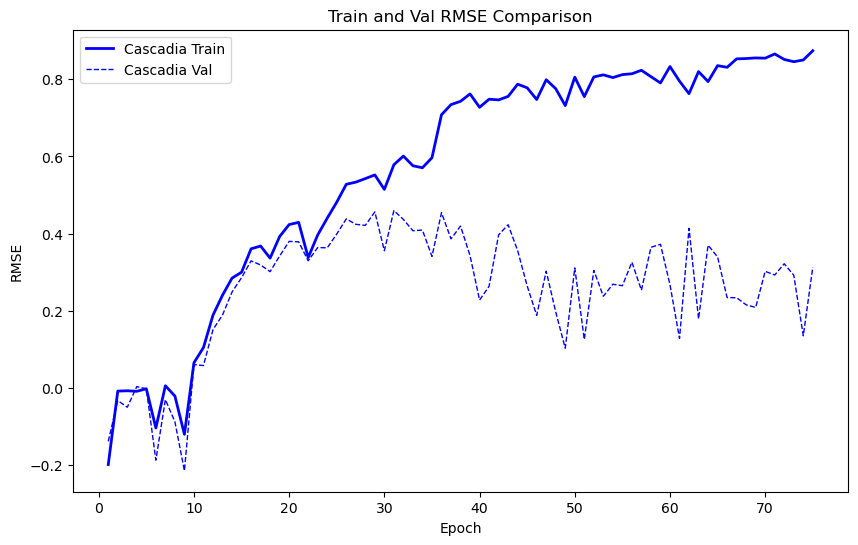

In [63]:
plt.figure(figsize=(10, 6))

# Plot Cascadia train and val RMSE
plt.plot(range(1, N_EPOCHS + 1), cascadia_results_dict["train_r2_list"], color='blue', linestyle='-', linewidth=2, label='Cascadia Train')
plt.plot(range(1, N_EPOCHS + 1), cascadia_results_dict["val_r2_list"], color='blue', linestyle='--', linewidth=1, label='Cascadia Val')


plt.title('Train and Val RMSE Comparison')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()